In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cvxpy as cp

(CVXPY) Jul 14 03:56:43 PM: Encountered unexpected exception importing solver PROXQP:
ImportError("dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/instructionset.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/libc++.1.dylib\n  Referenced from: <1A57AE5C-C7A4-3364-A443-4BC8EA7A0D79> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/instructionset.cpython-312-darwin.so\n  Reason: tried: '/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/var/folders/mj/dx2cc6hn6h9br7vt9hz4n06m0000gn/T/cmeel-0at3h7tz/whl/cmeel.prefix/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/var/folders/mj/dx2cc6hn6h9br7vt9hz4n06m0000gn/T/cmeel-0at3h7tz/whl/cmeel.prefix/l

In [2]:
np.random.seed(230824)

validation = False
SMC_global = True
graph = True

## data generation

# dimensions
n,m,d = int(2e2),int(1e3),int(100)

main_scale_beta = 25.0 # granurality 
delta_beta = 15 #.2 # in fraction of bar_beta norm along a random direction 
inflation_factor = .2 
rank_B_dev = min(4,d)
impact_B_dev = .2 # in fraction of average EV of B_def

# ref vectors
bar_beta = np.random.randint(-int(max(1,abs(main_scale_beta))),int(max(1,abs(main_scale_beta)))+1,d)/int(max(1,abs(main_scale_beta)))
norm_bar_beta = np.linalg.norm(bar_beta)
pre_diag_B_ref = np.random.uniform(.25,1.0,d)
diag_B_ref = pre_diag_B_ref / np.sum(pre_diag_B_ref) * d 
mean_EV = np.mean(diag_B_ref)
R_base = np.sqrt(np.sum(np.abs(diag_B_ref*np.ones(d))**2)*(1+inflation_factor))


# deviations
betas = np.outer(np.ones(n),bar_beta)
for i in range(n):
    dev_i = np.random.normal(0,1,d)
    dev_i /= np.linalg.norm(dev_i)
    betas[i] += dev_i*delta_beta*norm_bar_beta

B_devs = []
for j in range(m):
    # Generate a random matrix with standard normal entries
    H = np.random.standard_normal(size=(d, d))
    # Compute QR decomposition
    Q, R = np.linalg.qr(H)
    # Adjust signs of Q to ensure uniform distribution
    diag_signs = np.sign(np.diag(R))
    diag_signs[diag_signs == 0] = 1  # Handle zero signs (unlikely)
    Q = Q * diag_signs  # Multiply each column by its sign
    B_devs.append(Q[:rank_B_dev,:])

In [3]:
## CVXPY base case
x_base = cp.Variable(d)
cstrs_base = [cp.sum_squares(cp.multiply(diag_B_ref**(1/2),x_base))<=R_base**2]
obj_base = cp.Minimize(bar_beta@x_base)
prob_base = cp.Problem(obj_base,cstrs_base)

In [4]:
prob_base.solve(solver=cp.MOSEK,verbose=True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jul 14 03:56:44 PM: Your problem has 100 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 14 03:56:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 03:56:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 03:56:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 14 03:56:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 03:56:44 PM: Compiling problem (target solver=MOSEK).
(C

-63.305245416735325

In [5]:
'''
cstr generator
''' 
def DOMGEN(cvxpy_var,S=np.arange(m),sc_factor=impact_B_dev):
    buf = []
    for j in S:
        buf.append(cp.sum_squares(cp.multiply(diag_B_ref**(1/2),cvxpy_var))+sc_factor*mean_EV*cp.sum_squares(B_devs[int(j)]@cvxpy_var)-R_base**2<=0)
    return buf.copy()

In [6]:
## CVXPY base case - full constraints
x_base_ext = cp.Variable(d)
cstrs_base_ext = DOMGEN(x_base_ext)
obj_base_ext = cp.Minimize(bar_beta@x_base_ext)
prob_base_ext = cp.Problem(obj_base_ext,cstrs_base_ext)

In [7]:
prob_base_ext.solve(solver=cp.MOSEK,verbose=False)

-61.98536204991189

In [8]:
def c_values(x,S=np.arange(m),sc_factor=impact_B_dev):
    inners = np.array(B_devs)[S]@x
    return np.sum((diag_B_ref**(1/2)*x)**2)-R_base**2 + sc_factor*mean_EV*np.sum(inners**2,1)

def active_cstr(x,sc_factor_bis=impact_B_dev,feasactive=1e-4):
    cvals = c_values(x,sc_factor=sc_factor_bis)
    return np.where(cvals>=-feasactive)[0]

def f_values(x,H=np.arange(n)):
    return betas[H]@x

def active_f(x,rho=1e-3):
    fvals = f_values(x)
    return np.where(fvals<=np.min(fvals)+rho)[0]

def F(x,feastol=1e-5):
    if np.max(c_values(x))>=feastol:
        return np.inf
    else:
        return np.min(f_values(x))

In [9]:
import time


if validation:

    reps = 10
    
    num_pieces = int(10)
    num_subsets = int(40)
    
    subset_sizes = np.sort(list(set([int(elem) for elem in np.logspace(0,np.log10(m),num_subsets)])))
    
    times_collected = np.zeros((num_pieces,len(subset_sizes),reps))
    pieces_ID = []
    
    for idi,i in enumerate(np.random.choice(np.arange(len(betas)),num_pieces,replace=False)):
        obj_i = cp.Minimize(betas[i]@x_base_ext)
        pieces_ID.append(i)
        print('ID piece => '+str(i))
        print(' ')
        for idsubset,S_size in enumerate(subset_sizes):
            print('#constraints = '+str(S_size))
            print(' ')
            for _ in range(reps):
                S_ = np.random.choice(np.arange(m),S_size,replace=False)
                cstrs_base_ext = DOMGEN(x_base_ext,S=S_)
                nu_i = cp.Problem(obj_i,cstrs_base_ext)
                ref_time = time.time()
                nu_i.solve(solver=cp.MOSEK,verbose=False)
                solving_time = max(0,time.time()-ref_time)
                times_collected[idi,idsubset,_] = solving_time
                print('rep #'+str(_)+' | time = '+str(solving_time))
            print(' ')

In [10]:
if validation:
    data_dic = {'piece':[],'|S|':[],'repID':[],'time':[]}
    for idi,i in enumerate(pieces_ID):
        for idsubset,S_size in enumerate(subset_sizes):
            for _ in range(reps):
                data_dic['piece'].append(i)
                data_dic['|S|'].append(S_size)
                data_dic['repID'].append(_+1)
                data_dic['time'].append(times_collected[idi,idsubset,_])

In [11]:
import pandas as pd

if validation:
    my_data_df = pd.DataFrame(data=data_dic)
    my_data_df.to_csv('oracle_times.csv')
else:
    my_data_df = pd.read_csv('oracle_times.csv',sep=',')
    subset_sizes = my_data_df['|S|'].unique()
    my_data_df.drop(columns=['Unnamed: 0'],inplace=True)

In [12]:
my_data_df

,piece,|S|,repID,time
0,0,1,1,0.013893
1,0,1,2,0.013153
2,0,1,3,0.012080
3,0,1,4,0.010744
4,0,1,5,0.010730
...,...,...,...,...
3395,64,1000,6,67.372391
3396,64,1000,7,67.297603
3397,64,1000,8,67.308043
3398,64,1000,9,70.749135


In [21]:
len(my_data_df['|S|'].unique())

34

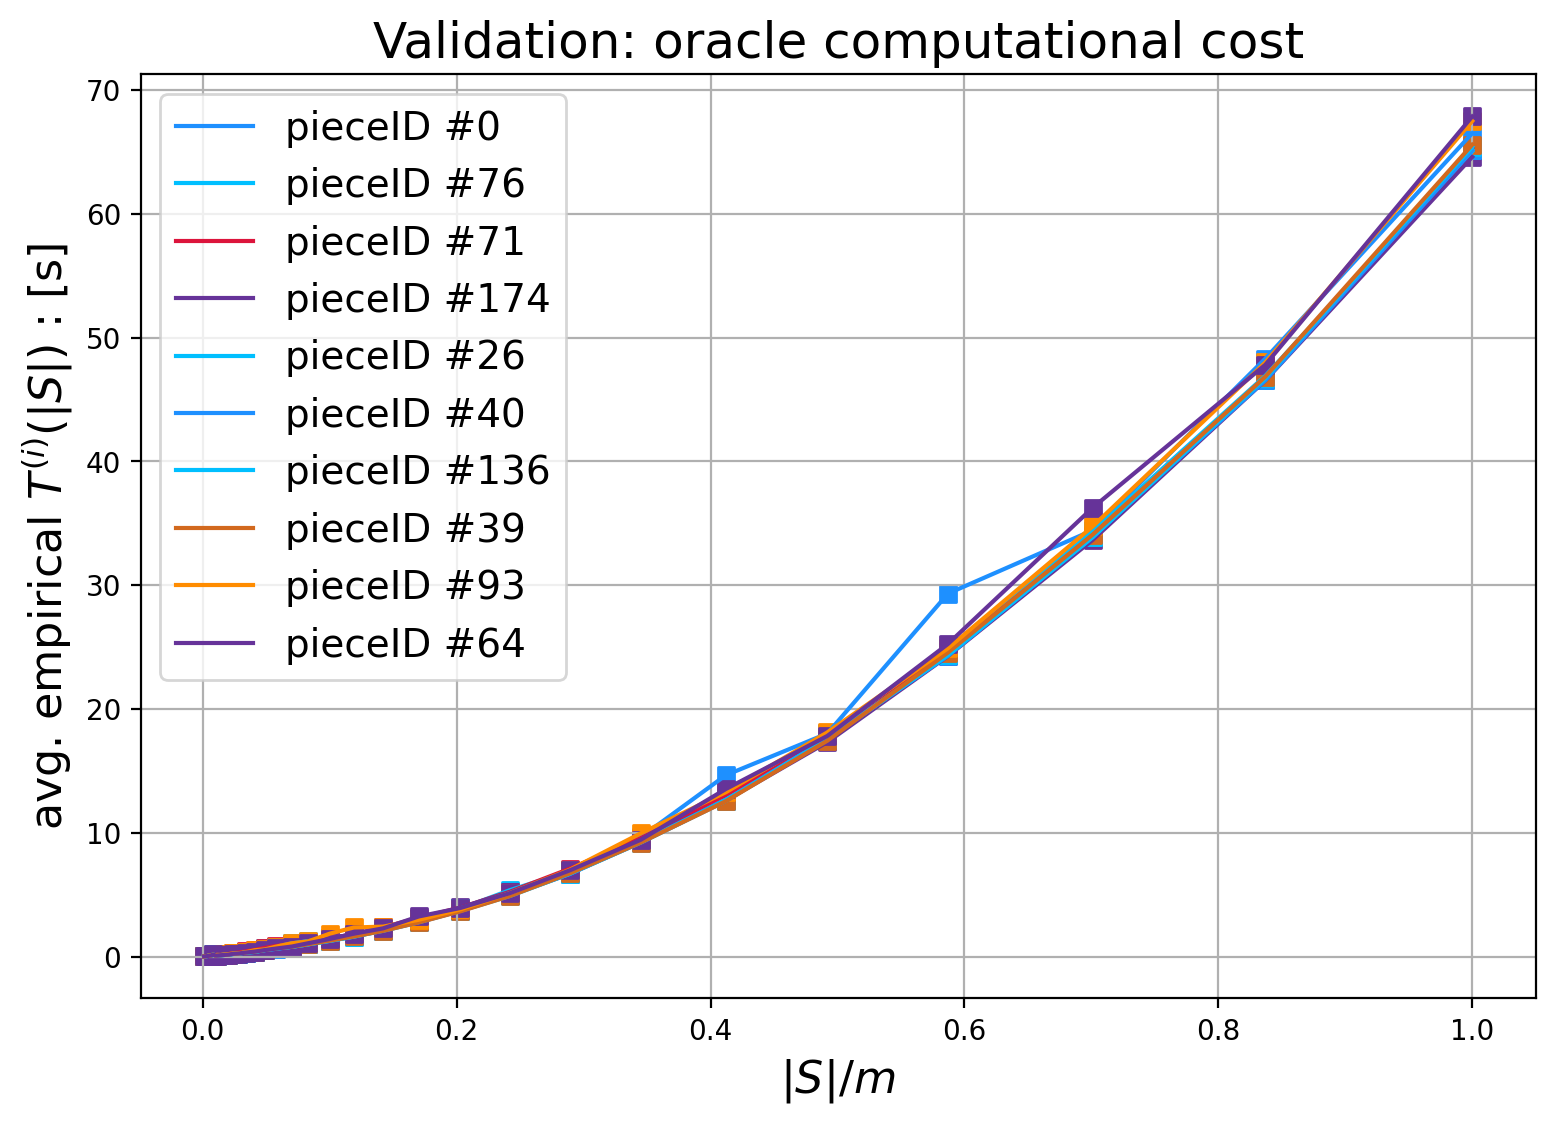

In [22]:
if graph:
    colors = ['dodgerblue', 'crimson', 'limegreen', 'darkorange', 'rebeccapurple',
              'gold', 'deepskyblue', 'deeppink', 'lawngreen', 'chocolate']
    plt.figure(figsize=(9,6))
    plt.title('Validation: oracle computational cost',fontsize=18)
    plt.grid()
    plt.xlabel('$|S|/m$',fontsize=16)
    plt.ylabel('avg. empirical $T^{(i)}(|S|)$ : [s]',fontsize=16)
    horizontal_ticks = subset_sizes/m
    for i in my_data_df['piece'].unique():
        subdf = my_data_df[my_data_df['piece']==i]
        avg_time = []
        std_2_mean = []
        for S_size in subset_sizes:
            me = subdf[subdf['|S|']==S_size]['time'].mean()
            std = subdf[subdf['|S|']==S_size]['time'].std()
            avg_time.append(me)
            std_2_mean.append(std/max(1e-3,abs(me)))
        print('for i = '+str(i)+' | std2mean = '+str(std_2_mean))
        plt.plot(horizontal_ticks,avg_time,label='pieceID #'+str(i),color=colors[i%len(colors)])
        plt.scatter(horizontal_ticks,avg_time,color=colors[i%len(colors)],marker='s')
    plt.legend(fontsize=14)
    plt.savefig('validation.pdf',dpi=300)

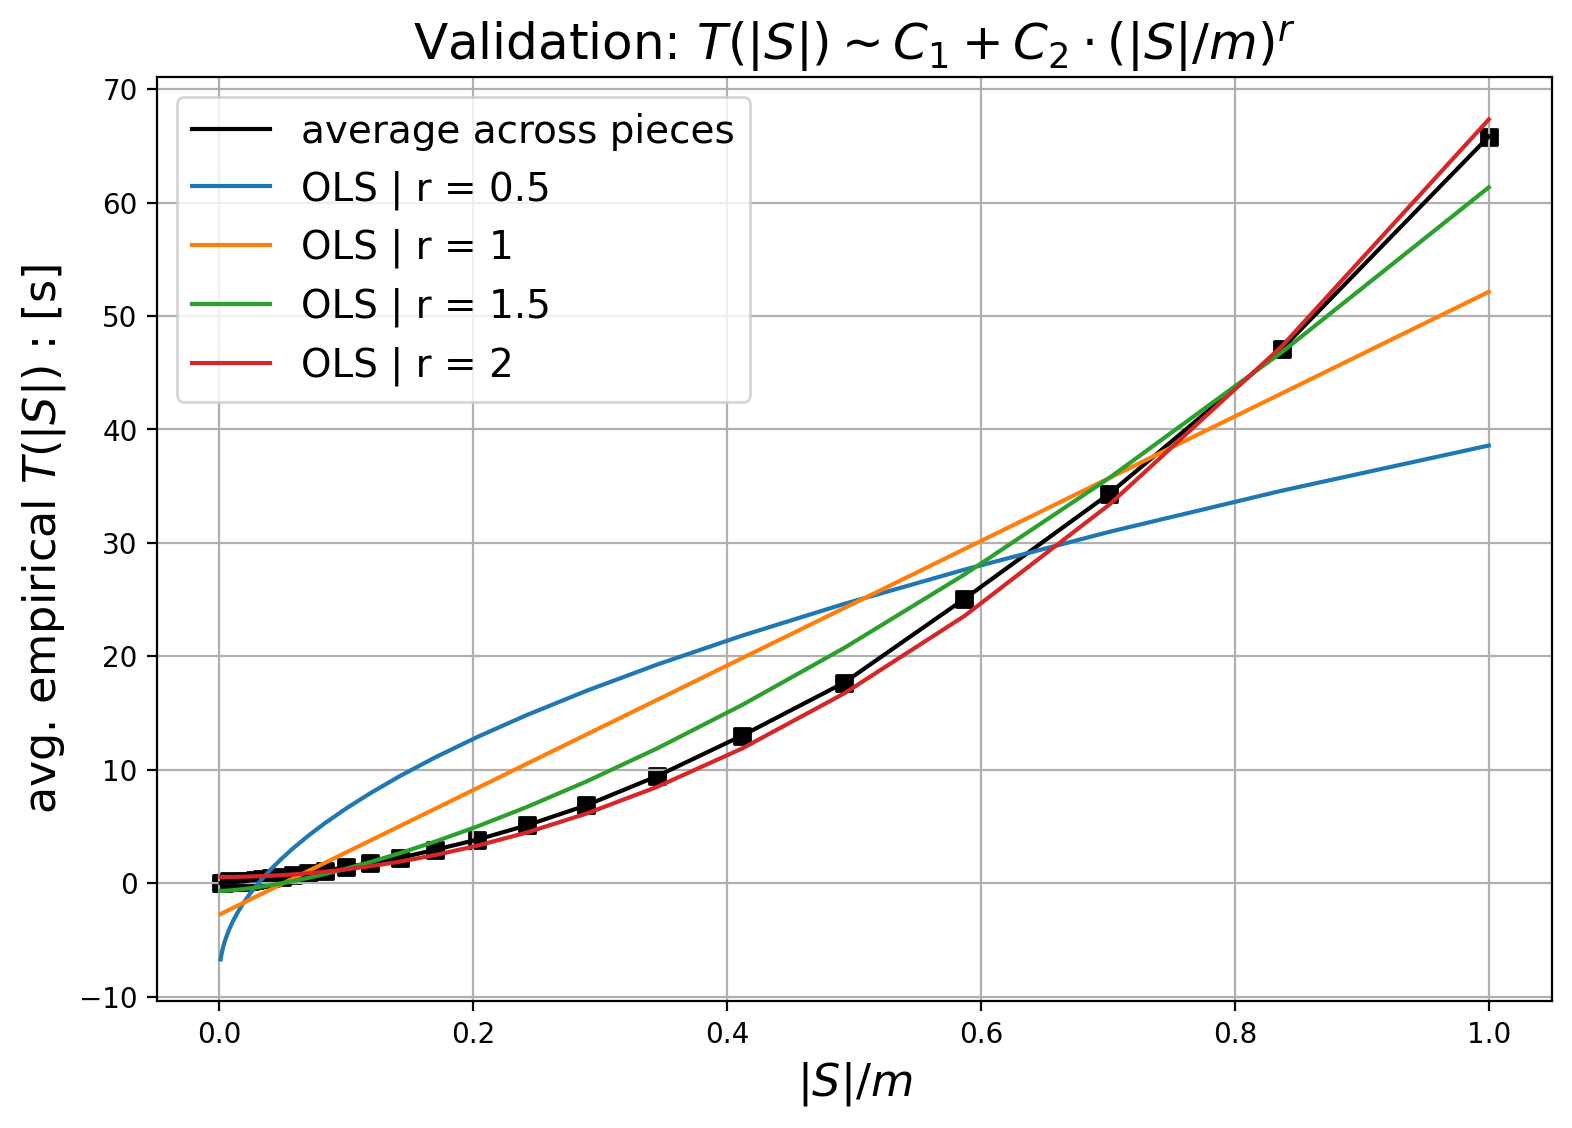

In [24]:
if graph:
    colors = ['dodgerblue', 'crimson', 'limegreen', 'darkorange', 'rebeccapurple',
              'gold', 'deepskyblue', 'deeppink', 'lawngreen', 'chocolate']
    plt.figure(figsize=(9,6))
    plt.title('Validation: $T(|S|) \\sim C_1 + C_2\\cdot (|S|/m)^r$',fontsize=18)
    plt.grid()
    plt.xlabel('$|S|/m$',fontsize=16)
    plt.ylabel('avg. empirical $T(|S|)$ : [s]',fontsize=16)
    horizontal_ticks = subset_sizes/m
    avg_time = []
    for S_size in subset_sizes:
        avg_time.append(my_data_df[my_data_df['|S|']==S_size]['time'].mean())
    plt.plot(horizontal_ticks,avg_time,label='average across pieces',color='black',linestyle='-')
    plt.scatter(horizontal_ticks,avg_time,color='black',marker='s')
    for r_test in [0.5,1,1.5,2]:
        features = np.column_stack([np.ones(len(avg_time)), np.asarray(horizontal_ticks**r_test)])
        coeffs = np.linalg.solve(features.T@features,features.T@avg_time)
        plt.plot(horizontal_ticks,coeffs[0]+coeffs[1]*horizontal_ticks**r_test,label='OLS | r = '+str(r_test))
    plt.legend(fontsize=14)
    plt.savefig('validation2.pdf',dpi=300)

In [16]:
## CVXPY global 
skip_print = True

if SMC_global:
    x_glob = cp.Variable(d)
    cstrs_full = DOMGEN(x_glob)
    lin_param_glob = cp.Parameter(d)
    eta_glob = cp.Variable(1)
    t_glob = cp.Variable(n,boolean=True)
    
    bigMs = np.zeros((n,n))
    
    for i_plus in range(n):
        if i_plus%10==0:
            hide = False
            if skip_print==False:
                print('i_plus = '+str(i_plus))
        else:
            hide = True
        for i in range(n):
            if i%10==0 and hide==False:
                if skip_print==False:
                    print('i = '+str(i))
            # closed-forms here
            if i_plus!=i:
                delta_betas = betas[i_plus]-betas[i]
                tilde_lin_c = delta_betas*(diag_B_ref**(-1/2))
                bigMs[i_plus,i] = np.linalg.norm(tilde_lin_c)*R_base

    cstrs_full += [cp.sum(t_glob)==1]

    for i_plus in range(n):
        cstrs_full += [betas[i_plus]@x_glob<=eta_glob[0]+bigMs[i_plus]@t_glob]

    prob_glob = cp.Problem(cp.Minimize(eta_glob[0]),cstrs_full)
    prob_glob.solve(solver=cp.GUROBI,verbose=True)
    

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jul 10 02:27:52 PM: Your problem has 301 variables, 1201 constraints, and 0 parameters.
(CVXPY) Jul 10 02:27:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 02:27:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 02:27:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 10 02:27:52 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 02:27:52 PM: Compiling problem (target solver=GUROBI)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [16]:
## CVXPY ULO 
x_ulo = cp.Variable(d)
cstrs_full = DOMGEN(x_ulo)
lin_param_ulo = cp.Parameter(d)
obj_ulo = cp.Minimize(lin_param_ulo@x_ulo)
prob_ulo_full = cp.Problem(obj_ulo,cstrs_full)

'''
inplace version of ULO
'''
def ULO(i_hat,epsilon_tilde=1e-2,epsilon=1e-2,verb_lvl=2):

    if verb_lvl>0:
        print('ULO start')
        print(' ')
    
    ## init.
    H,S = [],[]
    F_check,F_hat = -np.inf,np.inf
    rho = 1e-3
    i_star = None
    bar_x = None
    x_out = None
    k = 0

    nus = np.inf*np.ones(n)

    ## oracles set-up 
    
    ## main loop
    while k==0 or F_hat-F_check>max(epsilon,max(1,abs(F_hat))*epsilon_tilde):

        # -> phase (a) <- 
        R,V = np.inf,[i_hat]
        while len(V)>0:
            bar_i = np.random.choice(V)
            lin_param_ulo.value = betas[bar_i]
            H.append(bar_i)
            ### start oracle call 
            if verb_lvl>=1:
                print('tested piece #'+str(bar_i))
            prob_ulo_full.solve(solver=cp.MOSEK,warm_start=True)
            x_tilde = x_ulo.value
            nu_bar_i = prob_ulo_full.value
            if verb_lvl>=1:
                print('value: '+str(nu_bar_i))
            nus[bar_i] = nu_bar_i
            ### end oracle call 
            if nu_bar_i >= R:
                V = np.setdiff1d(V,[bar_i])
            else:
                V = np.setdiff1d(active_f(x_tilde,rho),H)
                R = F(x_tilde)
                i_star = bar_i
                bar_x = x_tilde

        ### update of the set of selected constraints
        S = np.union1d(S,[np.random.choice(np.setdiff1d(np.arange(m),S))])
        S = np.union1d(S,active_cstr(bar_x))

        val_bar_x = F(bar_x)
        if val_bar_x<F_hat:
            F_hat,x_out = val_bar_x,bar_x

        if F_hat-F_check<=max(epsilon,max(1,abs(F_hat))*epsilon_tilde):
            if verb_lvl>0:
                print(' ')
                print('early convergence within iteration #'+str(k))
            return x_out,F_hat,F_check,nus

        if verb_lvl>=1:
            print('F_hat = '+str(F_hat))
            if verb_lvl>=2:
                print('|S| = '+str(len(S)))

        # -> phase (b) <-
        for i in np.setdiff1d(range(n),H):
            ### start oracle call 
            cstrs_S = DOMGEN(x_ulo,S)
            lin_param_ulo.value = betas[i]
            prob_ulo_S = cp.Problem(obj_ulo,cstrs_S)
            if verb_lvl>=3:
                print('tested (LB) piece #'+str(i))
            prob_ulo_S.solve(solver=cp.MOSEK,warm_start=True)
            nus[i] = prob_ulo_S.value
            if verb_lvl>=3:
                print('value: '+str(nus[i]))
            ### end oracle call 
            
        i_hat = np.argmin(nus)
        F_check = max(F_check,nus[i_hat])
        if verb_lvl>=1:
            print('F_check = '+str(F_check))

        k += 1
        
    if verb_lvl>0:
        print(' ')
        print('convergence after '+str(k)+' iterations')
        
    return x_out,F_hat,F_check,nus


KeyboardInterrupt



In [ ]:
ULO(i_hat=np.random.choice(np.arange(n)),epsilon_tilde=1e-6,epsilon=1e-2)

In [ ]:
import gurobipy as gp
from gurobipy import GRB

time_setup_start = time.time()

## deepSeek generated 
model = gp.Model('bilinear')

scale = impact_B_dev*mean_EV

d = diag_B_ref.shape[0]
x_gurobi = model.addMVar(d, lb=-gp.GRB.INFINITY, name='x')
q_gurobi = model.addMVar(n, lb=0, name='weights')

for j, dev_j in enumerate(B_devs):
    quad_expr = gp.QuadExpr()

    for i in range(d):
        coeff = diag_B_ref[i]
        
        if abs(coeff) > 1e-10:
            quad_expr.addTerms(coeff, x_gurobi[i].item(), x_gurobi[i].item())
    
    for k in range(rank_B_dev):  
        row_k = dev_j[k, :]
        lin_expr = gp.LinExpr()
        for idx in range(d):
            coeff = row_k[idx]
            if abs(coeff) > 1e-10:
                lin_expr.addTerms(coeff, x_gurobi[idx].item())
        if lin_expr.size() > 0:
            quad_expr.add(scale * (lin_expr * lin_expr))
    
    model.addConstr(quad_expr <= R_base**2, name=f'qc_{j}')

main_obj = gp.QuadExpr() 
for i in range(n):
    for _ in range(d):
        main_obj.addTerms(betas[i][_],q_gurobi[i].item(),x_gurobi[_].item())

selec = gp.LinExpr()
for i in range(n):
    selec.addTerms(1.0,q_gurobi[i].item())

model.addConstr(selec==1.0,name='selection_required')

model.setObjective(main_obj, GRB.MINIMIZE)

time_setup_end = time.time()
TIME_GUROBIPY_setup = time_setup_end-time_setup_start

In [ ]:
TIME_GUROBIPY_setup

In [ ]:
t_start= time.time()
model.setParam('OutputFlag', 1)
model.optimize()
t_end = time.time()
TIME_GUROBIPY = t_end-t_start